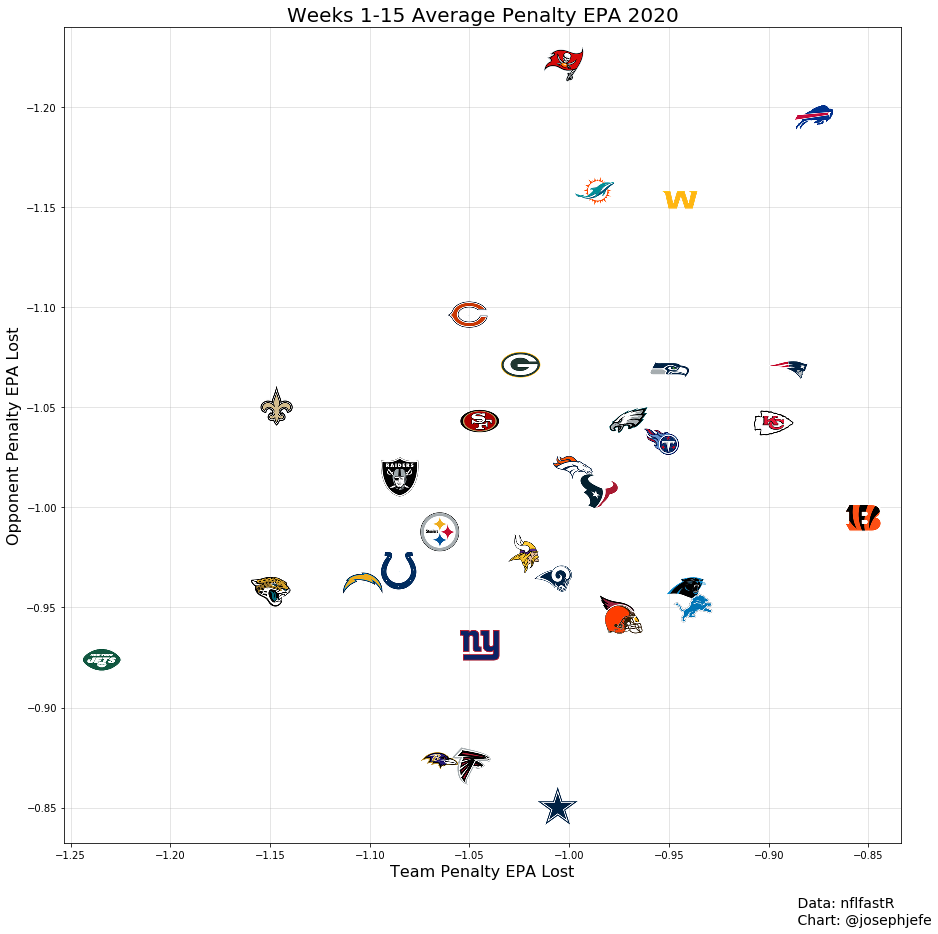

In [2]:
import pandas as pd
import numpy as np
YEAR = 2020
filePath = '/Users/Firefly/Desktop/_iMac_Drive/Joseph/Coding/NFL/Jupyter/'

# Choose whether you want the 'raw_play_by_play' or 'cleaned_play_by_play' data 
file = 'raw_play_by_play_'
#file = 'cleaned_play_by_play_'

# Import data
data = pd.read_csv(filePath + file + str(YEAR) + '.csv.gz', compression='gzip', low_memory=False)

# These two lines set the scroll options so you can scroll vertically and horizontally.
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

data = data.loc[data.season_type=='REG']
penalty_data = data.loc[(data.penalty==1)].copy()
#penalty_data = penalty_data.loc[(penalty_data.week>=15)]

# assign week as a variable that returns the lastest week
minWeek = penalty_data['week'].min()
maxWeek = penalty_data['week'].max()

# Basically what I want to do here is create a dataframe with average epa numbers 
# for penalties for and against a team
# This would be the pseudo-logic
# penalty_team_epa = average epa of all penalties vs penalty team
# opponent_penalty_epa = average epa of all penalties vs opponents team

penalty_data = penalty_data[['penalty_team', 'posteam', 'defteam', 'home_team', 'away_team', 'epa', 'play_id', 'game_id', 'desc', 'play_type_nfl']]
 
penalty_data['penalty_opponent'] = np.where(penalty_data['penalty_team'] != penalty_data['home_team'], penalty_data['home_team'], penalty_data['away_team']) 

# EPA is calculated for the posteam, which means that if the defteam commits a penalty, the epa needs 
# to be reversed in order to correctly calculate the total epa. 
penalty_data['p_team_epa'] = np.where(penalty_data['penalty_team'] == penalty_data['posteam'], penalty_data['epa'], (penalty_data['epa'] - (penalty_data['epa'] * 2)))

team_epa = penalty_data.groupby(['penalty_team'])[['p_team_epa']].mean()

opponent_epa = penalty_data.groupby(['penalty_opponent'])[['p_team_epa']].mean()

import os
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.optimize import curve_fit

# Add logos to the dataframe
def getImage(filePath): 
    return OffsetImage(plt.imread(filePath), zoom=.5)

logos = os.listdir(filePath + 'team_logos')
if '.DS_Store' in logos:
    logos.remove('.DS_Store')

logo_paths = []

for i in logos:
    logo_paths.append(filePath + 'team_logos/' + str(i))
logo_paths.sort()

#Define x (horizontal) and y (vertical) axis
x = team_epa.p_team_epa
y = opponent_epa.p_team_epa
 
#Create a figure with size 12x12
fig, ax = plt.subplots(figsize=(15,15))

#Make a scatter plot first to get the points to place logos
ax.scatter(x, y, s=.001)

# Invert Y axis so that top right is best, as god intended
ax.invert_yaxis()

#Adding logos to the chart
for x0, y0, path in zip(x, y, logo_paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
    ax.add_artist(ab)
    
#Add a grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)

# Set whether title text should reflect single week or multiple weeks, then set title text
title_week = np.where(minWeek==maxWeek, ('Week ' + str(maxWeek)), ('Weeks ' + str(minWeek) + '-' + str(maxWeek)))
title_text = str(title_week) + ' Average Penalty EPA ' + str(YEAR)

#Adding labels and text
ax.set_xlabel('Team Penalty EPA Lost', fontsize=16)
ax.set_ylabel('Opponent Penalty EPA Lost', fontsize=16)
ax.set_title(str(title_text), fontsize=20)
plt.figtext(.80,.05,' Data: nflfastR \n Chart: @josephjefe' ,fontsize=14)

#Save the figure as a png
plt.savefig(filePath + 'Figures/' + str(title_text) + '.png', dpi=400)